<center><img src="images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Images
## Module 2, Lab 4: Recurrent Neural Networks

Recurrent Neural Networks (RNNs) are special types of networks that can capture the dynamics of sequences via repeating connections. In this exercise, you will learn how to use RNNs and apply them to a text classification problem.

You will learn:
- How to perform text transformation
- How to use pre-trained GloVe word embeddings
- How to set up a Recurrent Neural Network model
- How to train and test a RNN model

---
This lab uses a dataset from a small sample of Amazon product reviews. 

__Review dataset schema:__
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __log\_votes:__ Logarithm-adjusted votes log(1+votes)
* __isPositive:__ Whether the review is positive or negative (1 or 0)

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |


---
__Important notes:__ 
- One distinction between regular neural networks and recurrent neural networks (RNN) is that recurrent networks specialize in sequential data. With this dataset, you will use RNNs on the __reviewText__ field. You will assume that the text is made of words or tokens that are placed in a grammatically logical order. The RNN will understand the associations between the words through the recurrent connections. Eventually, it will learn to classify the text correctly (up to a certain accuracy level). 

- If you were interested in including the __summary__ field, you would either have to append the summary to the review text or train a separate model. In this lab you will train a RNN using only the __reviewText__ field so you can focus on learning the process and keep training time shorter.

## Index

- [Text Transformation](#Text-Transformation)
- [Using pre-trained GloVe word embeddings](#Using-pre-trained-GloVe-word-embeddings)
- [Setting-up the Recurrent Neural Network model](#Setting-up-the-Recurrent-Neural-Network-model)
- [Training and testing the model](#Training-and-testing-the-model)

In [1]:
# installing libraries
!pip install -U -q -r requirements.txt

In [2]:
import boto3, os, re, time
import numpy as np
import torch, torchtext
import pandas as pd
import matplotlib.pyplot as plt
from d2l import torch as d2l
from os import path
from collections import Counter
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchtext.vocab import GloVe
GloVe.url['6B'] = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
import sys
sys.path.insert(1, '..')
from MLUDTI_EN_M2_Lab4_quiz_questions import *
from MLUDTI_EN_M2_Lab4_rnn import RNN

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:551: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Text Transformation

In this section, you will process the __reviewText__ field and convert it into a form that works well with recurrent networks. To do this you will:
- Read the dataset, create train/validation split and fill-in the missing text fields.
- Create a vocabulary using the texts from the __reviewText__ field. 
    - This vocabulary has a unique integer value for each word in the vocabulary such as "car"->32, "house"->651, ... 
- Transform the texts by replacing the words with their corresponding unique integer values. 
    - For example: "Happy to own it" becomes [321, 6, 237, 8, 2].
- Use a fixed sequence length of 50 so that you can put the data into a memory efficient form and load it in batches. 
    - Longer texts are cut short (to 50 tokens) and shorter ones are padded a special value (1) to complete to 50 token length. 0 is used for unknown words (assume the real-world scenarios involving unknown words).

Start by reading in the dataset and looking at the first five rows.

In [3]:
df = pd.read_csv("data/NLP-REVIEW-DATA-CLASSIFICATION-TRAINING.csv")
df.head()

,ID,reviewText,summary,verified,time,log_votes,isPositive
0,65886,Purchased as a quick fix for a needed Server 2...,"Easy install, seamless migration",True,1458864000,0.000000,1
1,19822,So far so good. Installation was simple. And r...,Five Stars,True,1417478400,0.000000,1
2,14558,Microsoft keeps making Visual Studio better. I...,This is the best development tool I've ever used.,False,1252886400,0.000000,1
3,39708,Very good product.,Very good product.,True,1458604800,0.000000,1
4,8015,So very different from my last version and I a...,... from my last version and I am having a gre...,True,1454716800,2.197225,0


Now, look at the range and distribution of the target column `isPositive`.

In [4]:
df["isPositive"].value_counts()

isPositive
1    34954
0    21046
Name: count, dtype: int64

It is always important that you check the number of missing values for each column.

In [5]:
print(df.isna().sum())

ID             0
reviewText    11
summary       13
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


Since there are missing values in the text fields, specifically in the __reviewText__ field, you need to fill-in the missing values with an empty string.

In [6]:
df["reviewText"] = df["reviewText"].fillna("missing")

Now, split the dataset into training and validation.

In [7]:
# This separates 10% of the entire dataset into validation dataset.
train_text, val_text, train_label, val_label = train_test_split(
    df["reviewText"].tolist(),
    df["isPositive"].tolist(),
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

### Creating a vocabulary:

Once your dataset is ready, you need to create a vocabulary with the tokens from the text data. To do this, use a basic English tokenizer and then use these tokens to create the vocabulary. In this vocabulary, tokens will map to unique ids, such as "car"->32, "house"->651, ... 

In [8]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in train_text:
    counter.update(tokenizer(line))
vocab = vocab(counter, min_freq=2, specials=["<unk>"]) #min_freq>1 for skipping misspelled words
vocab.set_default_index(vocab['<unk>'])

To see what the data now looks like, print some examples.

In [9]:
print(f"'home' -> {vocab['home']}")
print(f"'wash' -> {vocab['wash']}")
# unknown word (assume from test set)
print(f"'fhshbasdhb' -> {vocab['fhshbasdhb']}")

'home' -> 665
'wash' -> 17661
'fhshbasdhb' -> 0


Now, print the words for the first 25 indexes in the vocabulary. 

- `< unk >` is reserved for unknown words 
- `< pad >` is used for the padded tokens (more about this in the next section)

In [10]:
print(vocab.get_itos()[0:25])

['<unk>', 'worked', 'great', '!', 'i', "'", 've', 'been', 'using', 'turbo', 'tax', 'for', 'at', 'least', 'ten', 'years', 'and', 'have', 'loved', 'it', 'from', 'the', 'start', '.', 'this']


In [11]:
question_1

### Text transformation with defined vocabulary

Now, you can use the vocabulary and map tokens in the text to unique ids of the tokens. 

For example: `["this", "is", "a", "sentence"] -> [14, 12, 9, 2066]`

In [12]:
# Let's create a mapper to transform our text data
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

Once the mapping is complete, you can print some before and after examples.

In [13]:
print(f"Before transform:\t{train_text[37]}")
print(f"After transform:\t{text_transform_pipeline(train_text[37])}")

Before transform:	Happy to own it.
After transform:	[817, 74, 47, 19, 23]


To make this process easier to use, create a function to do all the steps automatically. 

Create the function to: 

- Transform and pad (if necessary) the text data
- Cut the series of words at the point where it reaches a certain length
    - For this example, use `max_len=50`
    - If the text is shorter than max_len, pad `ones` to the start of the sequence

In [14]:
def pad_features(reviews_split, seq_length):
    # Transform the text
    # use the dict to tokenize each review in reviews_split
    # store the tokenized reviews in reviews_ints
    reviews_ints = []
    for review in reviews_split:
        reviews_ints.append(text_transform_pipeline(review))
    
    # getting the correct rows x cols shape
    features = np.ones((len(reviews_ints), seq_length), dtype=int)
    
    # for each review, I grab that review
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return torch.tensor(features, dtype=torch.int64)

Let's look at two example sentences. Remember that $1$ is used for each padded item and $0$ is used for each unknown word in the text.

In [15]:
for text in train_text[15:17]:
    print(f"Text: {text}\n")
    print(f"Original length of the text: {len(text)}\n")
    tt = pad_features([text], seq_length=50)
    print(f"Transformed text: \n{tt}\n")
    print(f"Shape of transformed text: {tt.shape}\n")

Text: Its just great as alwayes
Been using for years and its getting better

Original length of the text: 69

Transformed text: 
tensor([[  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1, 212, 261,   2,  30,   0,
           7,   8,  11,  15,  16, 212, 297, 332]])

Shape of transformed text: torch.Size([1, 50])

Text: By carefully selecting the options available, the latest Kindle for Windows on even a small laptop produces a very pleasant reading experience, even if your vision is not the best at your comfortable hands to eyes reading distance. It sure beats reading from a book whose font size is too small for comfort.

Original length of the text: 307

Transformed text: 
tensor([[333, 334, 335,  21, 336, 337,  49,  21,  76, 338,  11, 103, 154, 134,
          66, 339, 340, 341,  66, 247, 342, 343, 344,  49, 134, 293,  28, 345,
        

Use the `pad_features()` function and create the data loaders and use `max_len=50` to consider only the first 50 words in the text.

In [16]:
max_len = 50
batch_size = 64

# Pass transformed and padded data to dataset
# Create data loaders
train_dataset = TensorDataset(
    pad_features(train_text, max_len),
    torch.tensor(train_label)
)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          drop_last=True)

val_dataset = TensorDataset(pad_features(val_text, max_len),
                            torch.tensor(val_label))
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        drop_last=True)

## Using pre-trained GloVe word embeddings

In this example, you will use GloVe word vectors `name="6B"` with `dim=300`. This gives 6 billion words/phrases vectors. Each word vector has $300$ numbers. 

The following code shows how to get the word vectors and create an embedding matrix from them. You will connect your vocabulary indexes to the GloVe embedding with the `get_vecs_by_tokens()` function.

In [17]:
glove = GloVe(name="6B", dim=300)
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos())

Now you need to set your parameters such as number of epochs and the vocabulary size.

In [18]:
# Size of the state vectors
hidden_size = 128

# General NN training parameters
learning_rate = 0.001
num_epochs = 45

# Embedding vector and vocabulary sizes
embed_size = 300  # glove.6B.300d.txt
vocab_size = len(vocab.get_itos())

We need to put our data into correct format before the process.

# Recurrent Neural Networks

Interact with the basic word-level RNN below. Each sequence in the RNN is predicted from information in the previous hidden layer, as well as the previous word in the sequence:

In [19]:
RNN()

## Setting-up the Recurrent Neural Network model

The model is made of these layers:
- Embedding layer: 
    - Words/tokens are mapped to word vectors
- RNN layer: 
    - A simple RNN model
    - Stack 2 RNN layers
    - For more details about the RNN read the [PyTorch RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) documentation
- Linear layer: 
    - A linear layer with two neurons (for two output classes) is used to output the `isPositive` prediction

In [20]:
class Net(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=1)
        self.rnn = nn.RNN(
            embed_size, hidden_size, num_layers=num_layers, batch_first=True
        )

        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        # Call the RNN layer
        outputs, _ = self.rnn(embeddings)
        
        # Output shape after RNN: (batch_size, max_len, hidden_size)
        # Get the output from the last time step with outputs[:, -1, :] below
        # The output shape becomes: (batch_size, 1, hidden_size)
        # Send it through the linear layer
        return self.linear(outputs[:, -1, :])
    
# Initialize the weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.RNN:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

Now you can initialize the network and then make the embedding layer use the GloVe word vectors.

In [21]:
# Our architecture with 2 RNN layers
model = Net(vocab_size, embed_size, hidden_size,
            num_classes=2, num_layers=2)

# We set the embedding layer's parameters from GloVe
model.embedding.weight.data.copy_(embedding_matrix)
# We won't change/train the embedding layer
model.embedding.weight.requires_grad = False

## Training and testing the model

You are now ready to train the model. To do this, first define the evaluation and training functions.

In [22]:
def accuracy(y_hat, y):  
    """Compute the number of correct predictions."""
    pred = torch.argmax(y_hat, axis=1)
    return torch.sum(pred == y)

def eval_accuracy(net, data_loader):
    # Use accumulator to keep track of metrics: correct predictions, num of predictions
    metric = d2l.Accumulator(2)
    
    net.eval()
    for X, y in data_loader:
        y_hat = net(X)
        metric.add(accuracy(y_hat, y), y.numel())

    return metric[0] / metric[1]

print("Classification Accuracy:", eval_accuracy(model, val_loader))

Classification Accuracy: 0.5711206896551724


Finally! It is time to start the training process! 

To help see what is happening, after each epoch the cross-entropy loss will be printed.

In [23]:
# Train the network
def train_net(net, train_loader, test_loader, num_epochs=1, lr=0.001):
    
    net.apply(init_weights)
    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    
    # Collect training times for each epoch
    train_times = []
    # Collect train losses after each epoch
    train_losses = []
    # Collect train and test accuracy
    train_accs, test_accs = [], []

    net.train()
    for epoch in range(num_epochs):
        train_loss = 0
        metric = d2l.Accumulator(3)
        
        timer = d2l.Timer()
        timer.start()
        # Training loop
        for X, y in train_loader:
            # Compute gradients and update parameters
            y_hat = net(X)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            metric.add(l.item() * len(y), accuracy(y_hat, y), y.numel())
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
        timer.stop()
        
        # Store training times   
        train_times.append(timer.sum())            
        # Store the loss after one epoch of training    
        train_losses.append(train_loss)   
        # Store the train accuracy
        train_accs.append(train_acc)
        # Compute the test accuracy after one epoch
        test_acc = eval_accuracy(net, test_loader)
        test_accs.append(test_acc)
        
        print(f'epoch {epoch+1}, Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}, Val accuracy {test_acc:.4f},  Training time (s) {timer.sum():.4f}')

    return train_losses, train_accs, test_accs


To add clarity, define a function to plot the losses and accuracies.

In [24]:
# Plot the training losses
def plot_losses(train_losses, train_accs, test_accs):
    
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss values")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.plot(train_accs, "g", label="Train Accuracy")
    plt.plot(test_accs, "red", label="Validation Accuracy")
    plt.title("Accuracy values")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Now you can use the plotting function to display the results.

epoch 1, Train loss 0.6737, Train accuracy 0.5962, Val accuracy 0.6334,  Training time (s) 25.0097
epoch 2, Train loss 0.6307, Train accuracy 0.6282, Val accuracy 0.6510,  Training time (s) 23.8268
epoch 3, Train loss 0.6073, Train accuracy 0.6513, Val accuracy 0.6756,  Training time (s) 21.8144
epoch 4, Train loss 0.5755, Train accuracy 0.6876, Val accuracy 0.7062,  Training time (s) 23.3669
epoch 5, Train loss 0.5506, Train accuracy 0.7116, Val accuracy 0.7223,  Training time (s) 21.1967
epoch 6, Train loss 0.5340, Train accuracy 0.7265, Val accuracy 0.7311,  Training time (s) 21.8558
epoch 7, Train loss 0.5211, Train accuracy 0.7372, Val accuracy 0.7412,  Training time (s) 23.5484
epoch 8, Train loss 0.5103, Train accuracy 0.7453, Val accuracy 0.7480,  Training time (s) 22.2668
epoch 9, Train loss 0.5007, Train accuracy 0.7517, Val accuracy 0.7516,  Training time (s) 23.9547
epoch 10, Train loss 0.4922, Train accuracy 0.7576, Val accuracy 0.7523,  Training time (s) 24.0477
epoch 11,

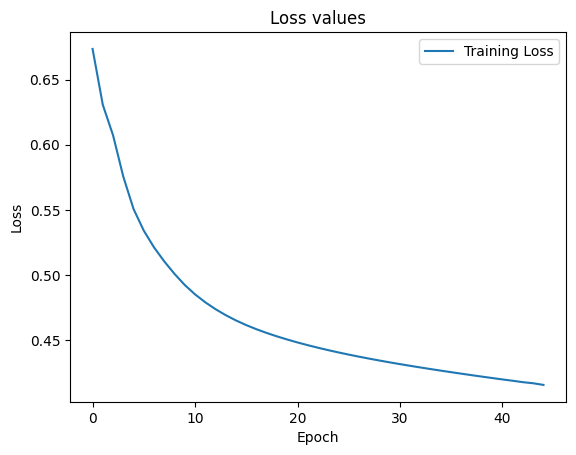

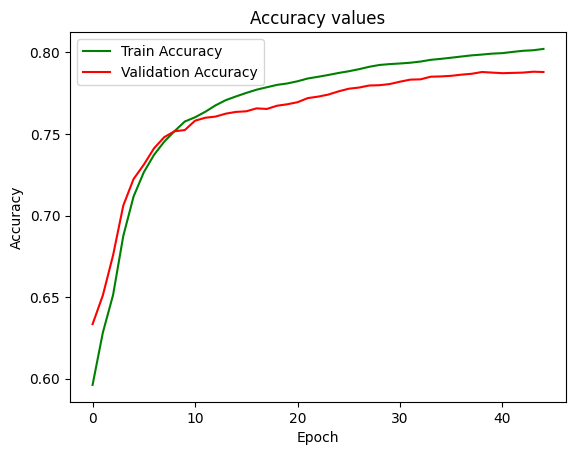

CPU times: user 34min, sys: 34.2 s, total: 34min 34s
Wall time: 18min 1s


In [27]:
%%time

train_losses, train_accs, val_accs = train_net(model, train_loader,
                                               val_loader, num_epochs=num_epochs,
                                               lr=learning_rate)

plot_losses(train_losses, train_accs, val_accs)

Finally, you can use the `eval_accuracy()` function to calculate validation set performance.

In [28]:
print("Classification Accuracy on Validation set:", eval_accuracy(model, val_loader))

Classification Accuracy on Validation set: 0.7878951149425287


When you look at the plots, you probably noticed that the model hasn't reached a plateau for the validation set. This indicates that your model has not train long enough. With this setup, the way to have your model train longer is to increase the number of `epochs` it trains. 

The number of `epochs` is set in the [Using pre-trained GloVe word embeddings](#Using-pre-trained-GloVe-word-embeddings) section.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
     <p style="text-align:center; margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p></ br>
    <p style=" text-align: center; margin: auto;">Increase the <code>num_epochs</code> parameter to a larger value (25, 30, ...)</p>
    <p style=" text-align: center; margin: auto;">Then, re-run the notebook</p>
    <p style=" text-align: center; margin: auto;">Did your <b> Validation </b> accuracy<b> improve</b>?
    </p>
</div>

----
## Conclusion

RNN's are a very important tools, especially for problems involving sequential data. You have learned how to build a simple RNN and use it to solve a sample problem. If you are further interested in improving your model, you can try the following:
- Change your hyper-parameters: Learning rate, batch size, and hidden size
- Increase the number of layers: num_layers
- Switch to [Gated Recurrent Units](https://pytorch.org/docs/1.9.1/generated/torch.nn.GRU.html) and [Long Sort-term Memory Networks](https://pytorch.org/docs/1.9.1/generated/torch.nn.LSTM.html).

--- 
## Next Lab: Finetuning the BERT model

Transformers have been extremely popular and successful models in Natural Language Processing problems. In the next lab you will learn how to use a previously trained transformer model called __"BERT"__ to solve a text classification problem. 